# Check alpha constraints for bispectrum

### Import all modules

In [2]:
import numpy as np
from numpy.linalg import inv,det
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.interpolate as interpolate
from scipy.interpolate import LinearNDInterpolator as lndi
import pandas as pd
import scipy.stats
import math

## Load data

In [6]:
Bk=np.load("bkr_z0.50.npz")
k=Bk['k']
br=Bk['bkr']
bkrm=Bk['bkrm'].T[0]

In [7]:
k.shape,br.shape,bkrm.shape

((2600, 3), (2600, 922), (2600,))

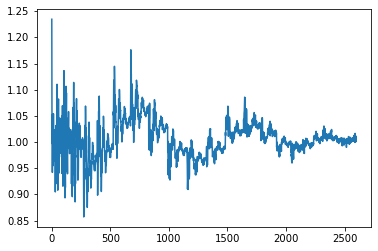

In [8]:
plt.plot(bkrm)

#### Removing folded triplets

In [36]:
folded=[i for i in range(len(k)) if k[i,0]+k[i,1]<=round(k[i,2]+0.015,4)]

In [37]:
k[folded]

array([[0.005, 0.005, 0.005],
       [0.005, 0.015, 0.015],
       [0.005, 0.025, 0.025],
       ...,
       [0.145, 0.155, 0.295],
       [0.145, 0.165, 0.295],
       [0.155, 0.155, 0.295]])

In [38]:
k=np.delete(k,folded,0)
br=np.delete(br,folded,0)
bkrm=np.delete(bkrm,folded,0)

In [39]:
k.shape,br.shape,bkrm.shape

((2158, 3), (2158, 957), (2158,))

In [9]:
k

array([[0.015, 0.135, 0.135],
       [0.015, 0.195, 0.195],
       [0.015, 0.275, 0.275],
       ...,
       [0.285, 0.285, 0.295],
       [0.285, 0.295, 0.295],
       [0.295, 0.295, 0.295]])

## Interpolation

#### 1. scipy.interpolate.RegularGridInterpolator

In [12]:
k1=np.unique(k[:,0])
k2=np.unique(k[:,1])
k3=np.unique(k[:,2])

kk1,kk2,kk3=np.meshgrid(k1,k2,k3)

tup_Bk=[tuple(i) for i in k[:,0:3]]

In [16]:
k1.shape,k2.shape,k3.shape

((29,), (28,), (28,))

In [13]:
output = np.empty(shape=(len(k1),len(k2),len(k3)))

for i in range(len(k1)):
    for j in range(len(k2)):
        for l in range(len(k3)):
            kkk=[i for i in permutations((kk1[i,j,l],kk2[i,j,l],kk3[i,j,l]))]
            if any(set(kkk).intersection(set(tup_Bk))):
                ind=tup_Bk.index(list(set(kkk).intersection(set(tup_Bk)))[0])
                output[i,j,l]=bkrm[ind]
            else:
                output[i,j,l]=np.nan                

IndexError: index 28 is out of bounds for axis 0 with size 28

In [ ]:
print(output[:2,:2,:2])

#### Interpolating the above 3d matrix(output) in itself so that the nan values (at positions where bk doesn't exist) gets filled. This is done only for the 3d interpolation purpose. The k-values at those positions won't be considered later anyway. 

In [44]:
output_fillnan=output.flatten()
output_fillnan=pd.DataFrame(output_fillnan)
output_fillnan=output_fillnan.interpolate(method='linear', limit_direction='forward', axis=0)

In [45]:
output_fillnan=np.array(output_fillnan)
output_fillnan=np.reshape(output_fillnan,(len(k1),len(k2),len(k3)))

In [46]:
output_fillnan[:2,:2,:2]

array([[[1.26593753, 1.25934658],
        [1.06820882, 1.06161787]],

       [[1.0288754 , 1.06161787],
        [1.06161787, 0.90241874]]])

In [47]:
ffb=rgi((k1,k2,k3),output_fillnan,method="linear",bounds_error=False,fill_value=None)
#plt.plot(ff((kg[:,0],kg[:,1],kg[:,2])))
#plt.plot(bg)

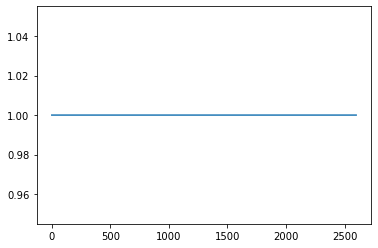

In [50]:
plt.plot(ffb((k))/bkrm)
#plt.plot(bkrm)

#### 2. scipy.interpolate.LinearNDInterpolator

In [34]:
ffb = lndi(k, bkrm)

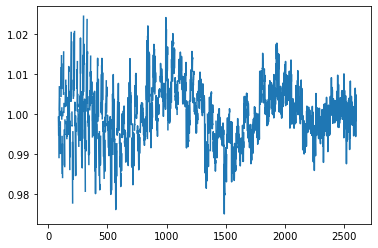

In [35]:
plt.plot(ffb((0.98*k))/bkrm)


### Masking/Slicing

In [40]:
def cutslice(kmin,kmax):
    is_good = np.ones(k.shape[0], '?')
    for i in range(3):is_good &= (k[:, i] > kmin) & (k[:, i] < kmax)
    kg = k[is_good, :]
    bg = bkrm[is_good]
    nbins, nmocks = br[is_good, :].shape
    hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
    cov = np.cov(br[is_good, :], rowvar=True)*hartlapf/ nmocks
    icov = inv(cov)
    print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}, hf = {hartlapf} , det_cov = {det(cov)}')
    return kg,bg,cov,hartlapf

In [68]:
hf=[]
for j in reversed(np.unique(k[:,0])[3:]):
    _,_,_,h=cutslice(0.005,j)
    hf.append(h)

kmax=0.295, kmin=0.005, nbins=1749, nmocks=957, hf = -1.2040302267002518 , det_cov = -0.0
kmax=0.285, kmin=0.005, nbins=1566, nmocks=957, hf = -1.5646481178396072 , det_cov = -0.0
kmax=0.275, kmin=0.005, nbins=1394, nmocks=957, hf = -2.1776765375854215 , det_cov = -0.0
kmax=0.265, kmin=0.005, nbins=1232, nmocks=957, hf = -3.4512635379061374 , det_cov = -0.0
kmax=0.255, kmin=0.005, nbins=1088, nmocks=957, hf = -7.18796992481203 , det_cov = -0.0
kmax=0.245, kmin=0.005, nbins=956, nmocks=957, hf = -956.0 , det_cov = 0.0
kmax=0.235, kmin=0.005, nbins=835, nmocks=957, hf = 7.966666666666667 , det_cov = 0.0
kmax=0.225, kmin=0.005, nbins=725, nmocks=957, hf = 4.156521739130435 , det_cov = 0.0
kmax=0.215, kmin=0.005, nbins=625, nmocks=957, hf = 2.896969696969697 , det_cov = 0.0
kmax=0.205, kmin=0.005, nbins=535, nmocks=957, hf = 2.276190476190476 , det_cov = 0.0
kmax=0.195, kmin=0.005, nbins=453, nmocks=957, hf = 1.904382470119522 , det_cov = 0.0
kmax=0.185, kmin=0.005, nbins=377, nmocks=957, 

In [41]:
kg,bg,cov,_=cutslice(0.005,0.085)

kmax=0.085, kmin=0.005, nbins=35, nmocks=957, hf = 1.0391304347826087 , det_cov = 2.0154419379248804e-75


## Chi-square test

In [42]:
def chisq(obs, exp, cov):
    delta=obs-exp
    cov_inv=inv(cov)
    return delta.dot(cov_inv.dot(delta))

In [47]:
alp=np.arange(0.98,1.02,0.002)
def chisq_alp(k,alp,cov):
    error=[]
    obs=ffb((k))
    for i in alp:
        exp=ffb((i*k))
        #pos_nan=[math.isnan(i) for i in exp]
        #print(k[pos_nan,:])
        #print(round(i,10),"\t",chisq(obs, exp, cov))
        error.append((chisq(obs, exp, cov)))
    return error

In [48]:
error=chisq_alp(kg,alp,cov)

In [49]:
lst=pd.DataFrame({"alpha":alp,"chi2":error})

In [50]:
lst

,alpha,chi2
0,0.980,0.363832
1,0.982,0.294704
2,0.984,0.232852
3,0.986,0.178277
4,0.988,0.130979
5,0.990,0.090958
6,0.992,0.058213
7,0.994,0.032745
8,0.996,0.014553
9,0.998,0.003638


In [109]:
datap = np.load("../GLAM_Ps/pk_error.npz")

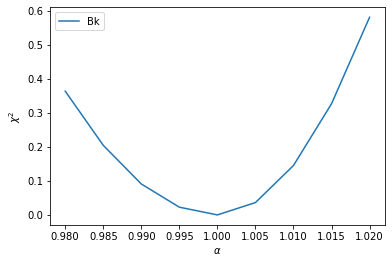

In [111]:
#plt.plot(datap["alp"],datap["error"],"-",label="Pk")
plt.plot(alp,error,"-",label="Bk")
#plt.ylim(-0.025,1)
#plt.xlim(0.985,1.015)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\chi^2$")
plt.legend()

### Plot chisq vs alpha for different kmax values

In [51]:
alp=np.linspace(0.85,1.15,1000)

kmin=0.005
kmax_min=0.045
kmax_max=0.2
all_errors=[]
all_kmax=[]
for kmax in reversed(np.unique(k[:,0])):
    if kmax>kmax_min and kmax<kmax_max:
        ki,bki,covi,_=cutslice(kmin,kmax)
        errori=chisq_alp(ki,alp,covi)
        all_errors.append(errori)
        all_kmax.append(kmax)
        print(kmax,np.min(errori))

kmax=0.195, kmin=0.005, nbins=531, nmocks=957, hf = 2.2547169811320753 , det_cov = 0.0
0.185 0.00772816998058589
kmax=0.175, kmin=0.005, nbins=378, nmocks=957, hf = 1.65684575389948 , det_cov = 0.0
0.175 0.005979483800284038
kmax=0.165, kmin=0.005, nbins=314, nmocks=957, hf = 1.4914196567862714 , det_cov = 0.0
0.165 0.004770076246444533
kmax=0.155, kmin=0.005, nbins=258, nmocks=957, hf = 1.3715925394548063 , det_cov = 0.0
0.155 0.004028619319900829
kmax=0.145, kmin=0.005, nbins=209, nmocks=957, hf = 1.2815013404825737 , det_cov = 0.0
0.145 0.0024038045041445116
kmax=0.135, kmin=0.005, nbins=164, nmocks=957, hf = 1.2085967130214919 , det_cov = 0.0
0.135 0.0011750608854155758
kmax=0.125, kmin=0.005, nbins=128, nmocks=957, hf = 1.1559854897218864 , det_cov = 0.0
0.125 0.0008128279642198407
kmax=0.115, kmin=0.005, nbins=98, nmocks=957, hf = 1.1155192532088682 , det_cov = 5.51238903582538e-264
0.115 0.0004841545944023409
kmax=0.105, kmin=0.005, nbins=72, nmocks=957, hf = 1.0826727066817667 

Text(0.5, 0, 'alpha')

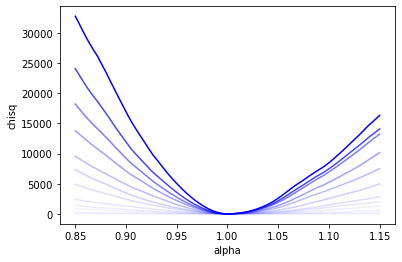

In [25]:
alpha = np.geomspace(1,0.01,len(all_errors))
for i,error in enumerate(all_errors):
    plt.plot(alp,error,alpha=alpha[i],color = 'b')
plt.ylabel("chisq")
plt.xlabel("alpha")
#plt.savefig("all_chisq.png")

### 1sigma constriant vs kmax

Find 1sigma confidence interval (of chisq vs alpha plot) for different kmax.

In [26]:
def find_1sigma(error,llim,rlim):
    least=np.min(error)
    #print(least)
    ffe=interpolate.interp1d(alp,error,fill_value="extrapolate")
    alp2=np.linspace(0.85,1.15,2000000)
    ind=np.where((ffe(alp2)<1+least+rlim) & (ffe(alp2)>1+least-llim))
    print(ind)
    left=ind[0][0]
    right=ind[0][-1]
    print(alp2[left]-alp2[right])
    return alp2[right]-alp2[left]

In [27]:
sigma=[]
count=1
for i in all_errors:
    sigma.append(find_1sigma(i,0.001/count,0.001/count))
    count=count+2

(array([ 996025,  996026,  996027,  996028, 1006848, 1006849, 1006850,
       1006851, 1006852, 1006853, 1006854, 1006855]),)
-0.0016245008122505178
(array([ 994986,  994987, 1007235, 1007236]),)
-0.0018375009187503455
(array([ 994487,  994488, 1007717, 1007718]),)
-0.0019846509923253652
(array([ 993955, 1009039, 1009040]),)
-0.002262751131375529
(array([1010451, 1010452]),)
-1.5000007502763424e-07
(array([ 990959, 1013209]),)
-0.0033375016687509085
(array([ 989582, 1017510]),)
-0.004189202094600941
(array([ 985678, 1020018]),)
-0.005151002575501384
(array([ 981009, 1025346]),)
-0.006650553325276531
(array([ 977496, 1037078, 1037079]),)
-0.00893745446872718
(array([ 961141,  961142, 1051409, 1051410, 1051411]),)
-0.013540506770253424
(array([ 924387,  924388,  924389,  924390, 1086433, 1086434, 1086435,
       1086436]),)
-0.024307362153681122
(array([ 909413,  909414,  909415,  909416, 1177935, 1177936, 1177937,
       1177938, 1177939, 1177940, 1177941, 1177942]),)
-0.040279370139685

In [86]:
plt.plot(all_kmax,sigma/2)
plt.xlabel("kmax")
plt.ylabel("1sigma_alpha")
#plt.savefig("1sigma_alpha_vs_kmax_covmat.png")

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [276]:
np.savez('bkk_1sigma.npz', kmax=all_kmax, sigmahf=sigmaf,sigma=sigma,hf=hf[10:25])


In [277]:
datab = np.load('bkk_1sigma.npz')

In [279]:
df= pd.DataFrame.from_dict({item: datab[item] for item in datab.files}, orient='index')


In [280]:
df.T

,kmax,sigmahf,sigma,hf
0,0.195,0.002177,0.001083,4.111607
1,0.185,0.002415,0.001420,2.851393
2,0.175,0.002722,0.001833,2.235437
3,0.165,0.002967,0.002162,1.871951
4,0.155,0.003362,0.002625,1.635879
5,0.145,0.004098,0.003379,1.471246
6,0.135,0.004875,0.004190,1.352423
7,0.125,0.005738,0.005103,1.263374
8,0.115,0.007272,0.006643,1.196104
9,0.105,0.009296,0.008684,1.144099
